# Import Packages and Load Variables

In [295]:
import uproot
print("uproot version: ", uproot.__version__)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import pickle
from collections import Counter
from particle import Particle

import awkward as ak

f = uproot.open('/Users/katherinepulido/Desktop/SURPRISE_Test_Samples_v10_04_07_05_Run4b_hyper_unified_reco2_BNB_nu_NC_pi0_overlay_may8_reco2_hist_62280465_snapshot.root')
fdirt = uproot.open('/Users/katherinepulido/Downloads/SURPRISE_Test_Samples_v10_04_07_05_Run4b_hyper_unified_reco2_BNB_dirt_may8_reco2_hist_62280564_snapshot.root')
fnu = uproot.open('/Users/katherinepulido/Downloads/SURPRISE_Test_Samples_v10_04_07_05_Run4b_super_unified_reco2_BNB_nu_overlay_reco2_hist.root')

uproot version:  5.6.2


## pi0 file loading

In [296]:
T_bdt_vars = []              # variables involved with BDT training (if you want to train your own BDT, lots of these variables will be useful)
                            # many of these variables describe specific features of the WC spacepoints using this code: https://github.com/BNLIF/wire-cell-pid/blob/master/src/NeutrinoID_nue_tagger.h
#    'single_photon_ncpi0_score',                        # here, we just include higher level outputs:
##    "nue_score",                    # BDT score for nue selection, used for the WC inclusive nueCC analysis
 #   "numu_score",                   # BDT score for numu selection, used for the WC inclusive numuCC selections
 #   "nc_delta_score",               # BDT score for NC Delta selection
 #   "nc_pio_score",                 # BDT score for NC pi0 selection
 #   "numu_cc_flag",                 # flag, -1 means not generic selected, 0 means generic selected, 1 means cut-based numuCC selected. We often use "numu_cc_flag >= 0" to apply generic neutrino selection.
#]

T_eval_vars = [             # variables involved with low level reconstruction and truth information
    "run",                         # run number
    "subrun",                       # subrun number
    "event",                        # event number
    "match_isFC",                   # reconstructed cluster is fully contained (FC), boolean
    "truth_nuEnergy",               # true neutrino energy (MeV)
    "truth_nuPdg",                  # true neutrino pdg code
    "truth_isCC",                   # true interaction type is charged current, boolean
    "match_completeness_energy",    # the true energy deposited in the clusters that are 3D-matched with the reconstructed neutrino clusters (MeV)
    "truth_energyInside",           # the true energy deposited in the TPC Fiducial Volume (MeV)
    "truth_vtxInside",              # boolean, true neutrino vertex is inside the TPC Fiducial Volume
    "truth_vtxX",                   # true neutrino vertex x (cm)
    "truth_vtxY",                   # true neutrino vertex y (cm)
    "truth_vtxZ",                   # true neutrino vertex z (cm)
    "weight_cv",                    # GENIE MicroBooNE tune event weight (which should be corrected by also using weight_spline)
    "weight_spline",                # additional weight to correct the GENIE tune for certain events
]
T_eval_data_vars = [        # same as above, but for data files we do not attempt to load any truth information
    "run",
    "subrun",
    "event",
    "match_isFC",
]

T_kine_vars = [             # variables involved with kinematic reconstruction
    "kine_reco_Enu",                # reconstructed neutrino energy (MeV). "kine_reco_Enu > 0" is another way to apply generic neutrino selection.
    "kine_energy_particle",         # energy of each reco particle
    "kine_particle_type", # pdg code of each reco particle
    "kine_pio_mass",
    "kine_pio_energy_2",
    "kine_pio_flag"
]

T_pf_vars = [               # variables involved with individual particles
    "truth_NprimPio",
    "truth_NCDelta",
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "reco_muonMomentum",            # reconstructed muon momentum 4-vector (p_x, p_y, p_z, p_t), in (GeV/c, GeV/c, GeV/c, GeV)
    "reco_showerMomentum",          # reconstructed primary shower momentum 4-vector (p_x, p_y, p_z, p_t), in (GeV/c, GeV/c, GeV/c, GeV)
    "reco_showervtxX",
    "reco_showervtxY",
    "reco_showervtxZ",

    # truth shower = xyz ke

    'truth_corr_showervtxX', 
    'truth_corr_showervtxY', 
    'truth_corr_showervtxZ', 
    'truth_showerKE',

    # These variables are related to individual true particles
    "truth_Ntrack",
    "truth_id",
    "truth_pdg",
    "truth_mother",
    "truth_startMomentum",
    "truth_startXYZT",
    "truth_endXYZT",

    # These variables are related to individual reco particles
    "reco_Ntrack",
    "reco_id",
    "reco_pdg",
    "reco_mother",
    "reco_startMomentum",
    "reco_startXYZT",
    "reco_endXYZT",
]

T_pf_data_vars = [          # same as above, but for data files we do not attempt to load any truth information
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "reco_muonMomentum",
    "reco_showerMomentum",
    "reco_showervtxX",
    "reco_showervtxY",
    "reco_showervtxZ",
    "reco_Ntrack",
    "reco_id",
    "reco_pdg",
    "reco_mother",
    "reco_startMomentum",
    "reco_startXYZT",
    "reco_endXYZT",
    'kine_reco_Enu'
]

vars = {}
vars.update(f["wcpselection"]["T_BDTvars"].arrays(T_bdt_vars, library="np"))
vars.update(f["wcpselection"]["T_eval"].arrays(T_eval_vars, library="np"))
vars.update(f["wcpselection"]["T_KINEvars"].arrays(T_kine_vars, library="np"))
vars.update(f["wcpselection"]["T_PFeval"].arrays(T_pf_vars, library="np"))

vars.update(f["wcpselection"]["T_BDTvars"]['shw_sp_n_20mev_showers'].arrays(library="np"))
vars.update(f["wcpselection"]["T_BDTvars"]['shw_sp_20mev_showers'].arrays(library="np"))

file_POT = np.sum(f["wcpselection"]["T_pot"].arrays("pot_tor875good", library="np")["pot_tor875good"])
for col in vars:
    vars[col] = vars[col].tolist()
wc_df = pd.DataFrame(vars)

In [297]:
blip_vars = [
    "nblips_saved",
    "blip_x",
    "blip_y",
    "blip_z",
    #"blip_size",
    "blip_energy",
    "blip_charge",
    "blip_nplanes",
    "blip_proxtrkdist",
    "blip_proxtrkid",
    "blip_touchtrk",
    "blip_touchtrkid",
    #"blip_badwirefrac",
    "blip_pl0_nwires",
    "blip_pl1_nwires",
    "blip_pl2_nwires",
    "blip_pl0_bydeadwire",
    "blip_pl1_bydeadwire",
    "blip_pl2_bydeadwire",
    #"blip_pl0_centerwire",
    #"blip_pl1_centerwire",
    #"blip_pl2_centerwire",
    "blip_true_g4id",
    "blip_true_pdg",
    "blip_true_energy",
]

vars = {}
vars.update(f["nuselection"]["NeutrinoSelectionFilter"].arrays(blip_vars, library="np"))
for col in vars:
    vars[col] = vars[col].tolist()
blip_df = pd.DataFrame(vars)

blip_df

,nblips_saved,blip_x,blip_y,blip_z,blip_energy,blip_charge,blip_nplanes,blip_proxtrkdist,blip_proxtrkid,blip_touchtrk,blip_touchtrkid,blip_pl0_nwires,blip_pl1_nwires,blip_pl2_nwires,blip_pl0_bydeadwire,blip_pl1_bydeadwire,blip_pl2_bydeadwire,blip_true_g4id,blip_true_pdg,blip_true_energy
0,19,"[298.69, 198.05, 189.34, 201.86, 201.91, 256.0...","[105.67, 8.87, 24.1, 14.43, 12.12, 79.51, -21....","[43.15, 98.12, 100.04, 110.17, 111.08, 114.66,...","[7.45, 1.927, 1.311, 2.225, 1.368, 1.685, 14.6...","[184230.0, 47660.0, 32420.0, 55020.0, 33820.0,...","[2, 3, 2, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, ...","[180.8422, 76.05615, 90.60626, 73.14744, 70.93...","[8, 13, 13, 13, 13, 8, 13, 13, 13, 8, 8, 8, 8,...","[False, False, False, False, False, False, Fal...","[-9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -...","[7, 2, -9, 3, 1, -9, 1, 1, 3, -9, -9, 2, -9, -...","[-9, 2, 2, 2, 2, 1, -9, -9, 4, 1, 1, -9, 11, 3...","[4, 2, 2, 2, 2, 1, 9, 3, 3, 1, 1, 1, 5, 2, 2, ...","[False, False, False, False, True, False, True...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Tru...","[-9, 540, 330, 455, 454, -9, 361, 296, 5, -9, ...","[-9, 11, 11, 11, 11, -9, 11, -11, 2212, -9, -9...","[-9.0, 1.996, 1.504, 2.566, 1.644, -9.0, 38.60..."
1,107,"[92.24, 37.32, 121.33, 259.83, 220.75, 190.62,...","[57.13, 100.03, -111.57, -38.2, -46.65, -96.91...","[48.3, 96.46, 109.68, 113.97, 139.02, 140.94, ...","[0.342, 0.621, 0.384, 2.013, 7.874, 3.28, 4.64...","[8450.0, 15350.0, 9510.0, 49770.0, 194730.0, 8...","[2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, ...","[97.91623, 76.13307, 64.01479, 21.944483, 6.56...","[6, 6, 9, 10, 9, 9, 9, 9, 17, 17, 17, 27, 17, ...","[False, False, False, False, True, True, True,...","[-9, -9, -9, -9, 9, 9, 9, -9, -9, -9, -9, -9, ...","[-9, 2, 1, -9, 4, 3, -9, 2, -9, -9, 3, -9, -9,...","[1, 2, 1, 3, 10, -9, 3, -9, 2, 3, 2, 2, 3, 2, ...","[1, 1, 1, 1, 8, 2, 7, 2, 1, 4, 3, 2, 4, 2, 1, ...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[-9, -9, -9, -9, -9, -9, -9, -9, -9, 762, -9, ...","[-9, -9, -9, -9, -9, -9, -9, -9, -9, 11, -9, -...","[-9.0, -9.0, -9.0, -9.0, -9.0, -9.0, -9.0, -9...."
2,33,"[42.61, 37.13, 81.19, -17.37, 7.62, 10.93, 68....","[-12.07, -22.43, -49.42, 11.45, 97.61, -55.66,...","[128.33, 140.12, 155.02, 162.85, 188.8, 191.6,...","[9.387, 14.384, 1.712, 0.342, 0.645, 0.636, 4....","[232140.0, 355700.0, 42340.0, 8470.0, 15950.0,...","[2, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 2, 2, 2, 2, ...","[4.7942853, 2.0868254, 51.201664, 67.04394, 85...","[0, 0, 0, 0, 3, 0, 20, 20, 2, 3, 3, 3, 3, 3, 2...","[True, True, False, False, False, False, False...","[0, 0, -9, -9, -9, -9, -9, 20, -9, -9, -9, 3, ...","[-9, -9, 2, -9, 2, 1, 2, 9, -9, 1, 1, 4, -9, -...","[3, 3, 3, 1, 2, 1, 4, 8, 1, 2, 3, -9, 2, 2, -9...","[3, 6, 2, 1, 1, 1, 4, 10, 1, 2, 3, 4, 2, 1, 1,...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[-9, -9, -9, -9, -9, 228, 225, 240, -9, -9, -9...","[-9, -9, -9, -9, -9, 11, 11, 11, -9, -9, -9, -...","[-9.0, -9.0, -9.0, -9.0, -9.0, 0.64, 4.485, 6...."
3,25,"[-14.56, 78.37, 84.7, 77.77, 182.91, 64.39, 64...","[-114.04, -25.72, -6.49, -42.3, 18.46, -85.31,...","[574.5, 625.53, 637.3, 646.51, 674.94, 688.49,...","[1.13, 3.168, 12.142, 1.985, 0.68, 5.423, 7.0,...","[27940.0, 78340.0, 300260.0, 49090.0, 16820.0,...","[3, 3, 3, 3, 2, 2, 3, 2, 3, 2, 2, 3, 3, 3, 2, ...","[129.5866, 23.401148, 6.0316086, 14.807024, 99...","[18, 1, 1, 1, 0, 1, 1, 14, 14, 14, 19, 19, 19,...","[False, False, True, True, False, True, True, ...","[-9, -9, 1, 1, -9, 1, 1, -9, -9, -9, -9, -9, -...","[2, 4, 10, 3, 1, 3, 5, -9, 3, 3, -9, 2, 11, 11...","[3, 4, 9, 3, -9, -9, 8, 1, 2, -9, 1, 2, 11, 8,...","[2, 2, 5, 3, 1, 3, 4, 1, 3, 4, 1, 2, 5, 8, 1, ...","[False, False, True, False, False, False, Fals..."

In [298]:
# CRT and light variables

CRT_vars = [
    'crtveto', # closest distance between shw start and space points to 
    'CosmicIP',
    '_closestNuCosmicDist',
    'crthitpe',
]

PMT_vars = [
    'flash_pe_flash_matching_v', # vector of photo electrons 
    'flash_pe_flash_matching', # sum of above vector
    'slice_pe_flash_matching_v', # vector of predicted photoelectrons ? 
    'flash_time_flash_matching', # 
    'flash_y_flash_matching',
    'flash_z_flash_matching',
    'flash_timewidth_flash_matching',
    'flash_ywidth_flash_matching',
    'flash_zwidth_flash_matching',
    'nu_flashmatch_score',
    'nu_centerX',
    'nu_centerY',
    'nu_centerZ',
    'best_cosmic_flashmatch_score',
]

vars = {}
vars.update(f["nuselection"]["NeutrinoSelectionFilter"].arrays(PMT_vars, library="np"))
for col in vars:
    vars[col] = vars[col].tolist()
pmt_df = pd.DataFrame(vars)


## Dirt file loading

In [299]:
T_bdt_vars = []              # variables involved with BDT training (if you want to train your own BDT, lots of these variables will be useful)
                            # many of these variables describe specific features of the WC spacepoints using this code: https://github.com/BNLIF/wire-cell-pid/blob/master/src/NeutrinoID_nue_tagger.h
#    'single_photon_ncpi0_score',                        # here, we just include higher level outputs:
##    "nue_score",                    # BDT score for nue selection, used for the WC inclusive nueCC analysis
 #   "numu_score",                   # BDT score for numu selection, used for the WC inclusive numuCC selections
 #   "nc_delta_score",               # BDT score for NC Delta selection
 #   "nc_pio_score",                 # BDT score for NC pi0 selection
 #   "numu_cc_flag",                 # flag, -1 means not generic selected, 0 means generic selected, 1 means cut-based numuCC selected. We often use "numu_cc_flag >= 0" to apply generic neutrino selection.
#]

T_eval_vars = [             # variables involved with low level reconstruction and truth information
    "run",                         # run number
    "subrun",                       # subrun number
    "event",                        # event number
    "match_isFC",                   # reconstructed cluster is fully contained (FC), boolean
    "truth_nuEnergy",               # true neutrino energy (MeV)
    "truth_nuPdg",                  # true neutrino pdg code
    "truth_isCC",                   # true interaction type is charged current, boolean
    "match_completeness_energy",    # the true energy deposited in the clusters that are 3D-matched with the reconstructed neutrino clusters (MeV)
    "truth_energyInside",           # the true energy deposited in the TPC Fiducial Volume (MeV)
    "truth_vtxInside",              # boolean, true neutrino vertex is inside the TPC Fiducial Volume
    "truth_vtxX",                   # true neutrino vertex x (cm)
    "truth_vtxY",                   # true neutrino vertex y (cm)
    "truth_vtxZ",                   # true neutrino vertex z (cm)
    "weight_cv",                    # GENIE MicroBooNE tune event weight (which should be corrected by also using weight_spline)
    "weight_spline",                # additional weight to correct the GENIE tune for certain events
]
T_eval_data_vars = [        # same as above, but for data files we do not attempt to load any truth information
    "run",
    "subrun",
    "event",
    "match_isFC",
]

T_kine_vars = [             # variables involved with kinematic reconstruction
    "kine_reco_Enu",                # reconstructed neutrino energy (MeV). "kine_reco_Enu > 0" is another way to apply generic neutrino selection.
    "kine_energy_particle",         # energy of each reco particle
    "kine_particle_type", # pdg code of each reco particle
    "kine_pio_mass",
    "kine_pio_energy_2",
    "kine_pio_flag"
]

T_pf_vars = [               # variables involved with individual particles
    "truth_NprimPio",
    "truth_NCDelta",
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "reco_muonMomentum",            # reconstructed muon momentum 4-vector (p_x, p_y, p_z, p_t), in (GeV/c, GeV/c, GeV/c, GeV)
    "reco_showerMomentum",          # reconstructed primary shower momentum 4-vector (p_x, p_y, p_z, p_t), in (GeV/c, GeV/c, GeV/c, GeV)
    "reco_showervtxX",
    "reco_showervtxY",
    "reco_showervtxZ",

    # truth shower = xyz ke

    'truth_corr_showervtxX', 
    'truth_corr_showervtxY', 
    'truth_corr_showervtxZ', 
    'truth_showerKE',

    # These variables are related to individual true particles
    "truth_Ntrack",
    "truth_id",
    "truth_pdg",
    "truth_mother",
    "truth_startMomentum",
    "truth_startXYZT",
    "truth_endXYZT",

    # These variables are related to individual reco particles
    "reco_Ntrack",
    "reco_id",
    "reco_pdg",
    "reco_mother",
    "reco_startMomentum",
    "reco_startXYZT",
    "reco_endXYZT",
]

T_pf_data_vars = [          # same as above, but for data files we do not attempt to load any truth information
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "reco_muonMomentum",
    "reco_showerMomentum",
    "reco_showervtxX",
    "reco_showervtxY",
    "reco_showervtxZ",
    "reco_Ntrack",
    "reco_id",
    "reco_pdg",
    "reco_mother",
    "reco_startMomentum",
    "reco_startXYZT",
    "reco_endXYZT",
    'kine_reco_Enu'
]

blip_vars = [
    "nblips_saved",
    "blip_x",
    "blip_y",
    "blip_z",
    #"blip_size",
    "blip_energy",
    "blip_charge",
    "blip_nplanes",
    "blip_proxtrkdist",
    "blip_proxtrkid",
    "blip_touchtrk",
    "blip_touchtrkid",
    #"blip_badwirefrac",
    "blip_pl0_nwires",
    "blip_pl1_nwires",
    "blip_pl2_nwires",
    "blip_pl0_bydeadwire",
    "blip_pl1_bydeadwire",
    "blip_pl2_bydeadwire",
    #"blip_pl0_centerwire",
    #"blip_pl1_centerwire",
    #"blip_pl2_centerwire",
    "blip_true_g4id",
    "blip_true_pdg",
    "blip_true_energy",
]

# CRT and light variables

CRT_vars = [
    'crtveto', # closest distance between shw start and space points to 
    'CosmicIP',
    '_closestNuCosmicDist',
    'crthitpe',
]

PMT_vars = [
    'flash_pe_flash_matching_v', # vector of photo electrons 
    'flash_pe_flash_matching', # sum of above vector
    'slice_pe_flash_matching_v', # vector of predicted photoelectrons ? 
    'flash_time_flash_matching', # 
    'flash_y_flash_matching',
    'flash_z_flash_matching',
    'flash_timewidth_flash_matching',
    'flash_ywidth_flash_matching',
    'flash_zwidth_flash_matching',
    'nu_flashmatch_score',
    'nu_centerX',
    'nu_centerY',
    'nu_centerZ',
    'best_cosmic_flashmatch_score',
]

vars = {}
vars.update(fdirt["nuselection"]["NeutrinoSelectionFilter"].arrays(PMT_vars, library="np"))
vars.update(fdirt["wcpselection"]["T_BDTvars"].arrays(T_bdt_vars, library="np"))
vars.update(fdirt["wcpselection"]["T_eval"].arrays(T_eval_vars, library="np"))
vars.update(fdirt["wcpselection"]["T_KINEvars"].arrays(T_kine_vars, library="np"))
vars.update(fdirt["wcpselection"]["T_PFeval"].arrays(T_pf_vars, library="np"))
vars.update(fdirt["wcpselection"]["T_BDTvars"]['shw_sp_n_20mev_showers'].arrays(library="np"))
vars.update(fdirt["wcpselection"]["T_BDTvars"]['shw_sp_20mev_showers'].arrays(library="np"))
vars.update(fdirt["nuselection"]["NeutrinoSelectionFilter"].arrays(blip_vars, library="np"))
file_POT = np.sum(fdirt["wcpselection"]["T_pot"].arrays("pot_tor875good", library="np")["pot_tor875good"])

for col in vars:
    vars[col] = vars[col].tolist()
dirt_df = pd.DataFrame(vars)


## Nu file loading

In [300]:
T_bdt_vars = []              # variables involved with BDT training (if you want to train your own BDT, lots of these variables will be useful)
                            # many of these variables describe specific features of the WC spacepoints using this code: https://github.com/BNLIF/wire-cell-pid/blob/master/src/NeutrinoID_nue_tagger.h
#    'single_photon_ncpi0_score',                        # here, we just include higher level outputs:
##    "nue_score",                    # BDT score for nue selection, used for the WC inclusive nueCC analysis
 #   "numu_score",                   # BDT score for numu selection, used for the WC inclusive numuCC selections
 #   "nc_delta_score",               # BDT score for NC Delta selection
 #   "nc_pio_score",                 # BDT score for NC pi0 selection
 #   "numu_cc_flag",                 # flag, -1 means not generic selected, 0 means generic selected, 1 means cut-based numuCC selected. We often use "numu_cc_flag >= 0" to apply generic neutrino selection.
#]

T_eval_vars = [             # variables involved with low level reconstruction and truth information
    "run",                         # run number
    "subrun",                       # subrun number
    "event",                        # event number
    "match_isFC",                   # reconstructed cluster is fully contained (FC), boolean
    "truth_nuEnergy",               # true neutrino energy (MeV)
    "truth_nuPdg",                  # true neutrino pdg code
    "truth_isCC",                   # true interaction type is charged current, boolean
    "match_completeness_energy",    # the true energy deposited in the clusters that are 3D-matched with the reconstructed neutrino clusters (MeV)
    "truth_energyInside",           # the true energy deposited in the TPC Fiducial Volume (MeV)
    "truth_vtxInside",              # boolean, true neutrino vertex is inside the TPC Fiducial Volume
    "truth_vtxX",                   # true neutrino vertex x (cm)
    "truth_vtxY",                   # true neutrino vertex y (cm)
    "truth_vtxZ",                   # true neutrino vertex z (cm)
    "weight_cv",                    # GENIE MicroBooNE tune event weight (which should be corrected by also using weight_spline)
    "weight_spline",                # additional weight to correct the GENIE tune for certain events
]
T_eval_data_vars = [        # same as above, but for data files we do not attempt to load any truth information
    "run",
    "subrun",
    "event",
    "match_isFC",
]

T_kine_vars = [             # variables involved with kinematic reconstruction
    "kine_reco_Enu",                # reconstructed neutrino energy (MeV). "kine_reco_Enu > 0" is another way to apply generic neutrino selection.
    "kine_energy_particle",         # energy of each reco particle
    "kine_particle_type", # pdg code of each reco particle
    "kine_pio_mass",
    "kine_pio_energy_2",
    "kine_pio_flag"
]

T_pf_vars = [               # variables involved with individual particles
    "truth_NprimPio",
    "truth_NCDelta",
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "reco_muonMomentum",            # reconstructed muon momentum 4-vector (p_x, p_y, p_z, p_t), in (GeV/c, GeV/c, GeV/c, GeV)
    "reco_showerMomentum",          # reconstructed primary shower momentum 4-vector (p_x, p_y, p_z, p_t), in (GeV/c, GeV/c, GeV/c, GeV)
    "reco_showervtxX",
    "reco_showervtxY",
    "reco_showervtxZ",

    # truth shower = xyz ke

    'truth_corr_showervtxX', 
    'truth_corr_showervtxY', 
    'truth_corr_showervtxZ', 
    'truth_showerKE',

    # These variables are related to individual true particles
    "truth_Ntrack",
    "truth_id",
    "truth_pdg",
    "truth_mother",
    "truth_startMomentum",
    "truth_startXYZT",
    "truth_endXYZT",

    # These variables are related to individual reco particles
    "reco_Ntrack",
    "reco_id",
    "reco_pdg",
    "reco_mother",
    "reco_startMomentum",
    "reco_startXYZT",
    "reco_endXYZT",
]

T_pf_data_vars = [          # same as above, but for data files we do not attempt to load any truth information
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "reco_muonMomentum",
    "reco_showerMomentum",
    "reco_showervtxX",
    "reco_showervtxY",
    "reco_showervtxZ",
    "reco_Ntrack",
    "reco_id",
    "reco_pdg",
    "reco_mother",
    "reco_startMomentum",
    "reco_startXYZT",
    "reco_endXYZT",
    'kine_reco_Enu'
]

blip_vars = [
    #"nblips_saved",
    "blip_x",
    "blip_y",
    "blip_z",
    #"blip_size",
    "blip_energy",
    "blip_charge",
    "blip_nplanes",
    "blip_proxtrkdist",
    "blip_proxtrkid",
    "blip_touchtrk",
    "blip_touchtrkid",
    #"blip_badwirefrac",
    "blip_pl0_nwires",
    "blip_pl1_nwires",
    "blip_pl2_nwires",
    "blip_pl0_bydeadwire",
    "blip_pl1_bydeadwire",
    "blip_pl2_bydeadwire",
    #"blip_pl0_centerwire",
    #"blip_pl1_centerwire",
    #"blip_pl2_centerwire",
    "blip_true_g4id",
    "blip_true_pdg",
    "blip_true_energy",
]

# CRT and light variables

CRT_vars = [
    'crtveto', # closest distance between shw start and space points to 
    'CosmicIP',
    '_closestNuCosmicDist',
    'crthitpe',
]

PMT_vars = [
    'flash_pe_flash_matching_v', # vector of photo electrons 
    'flash_pe_flash_matching', # sum of above vector
    'slice_pe_flash_matching_v', # vector of predicted photoelectrons ? 
    'flash_time_flash_matching', # 
    'flash_y_flash_matching',
    'flash_z_flash_matching',
    'flash_timewidth_flash_matching',
    'flash_ywidth_flash_matching',
    'flash_zwidth_flash_matching',
    'nu_flashmatch_score',
    'nu_centerX',
    'nu_centerY',
    'nu_centerZ',
    'best_cosmic_flashmatch_score',
]

vars = {}
vars.update(fnu["nuselection"]["NeutrinoSelectionFilter"].arrays(PMT_vars, library="np"))
vars.update(fnu["wcpselection"]["T_BDTvars"].arrays(T_bdt_vars, library="np"))
vars.update(fnu["wcpselection"]["T_eval"].arrays(T_eval_vars, library="np"))
vars.update(fnu["wcpselection"]["T_KINEvars"].arrays(T_kine_vars, library="np"))
vars.update(fnu["wcpselection"]["T_PFeval"].arrays(T_pf_vars, library="np"))
vars.update(fnu["wcpselection"]["T_BDTvars"]['shw_sp_n_20mev_showers'].arrays(library="np"))
vars.update(fnu["wcpselection"]["T_BDTvars"]['shw_sp_20mev_showers'].arrays(library="np"))
#vars.update(fnu["nuselection"]["NeutrinoSelectionFilter"].arrays(blip_vars, library="np"))
file_POT = np.sum(fnu["wcpselection"]["T_pot"].arrays("pot_tor875good", library="np")["pot_tor875good"])

for col in vars:
    vars[col] = vars[col].tolist()
nu_df = pd.DataFrame(vars)


## Post processing all files

In [311]:
# lee's code unedited

import sys
import uproot
import numpy as np
from tqdm import tqdm
import pickle
import argparse
import pandas as pd

#from helpers.plotting_3d import generate_box_edge_points, plot_event
#from helpers.spacepoint_sampling import fps_clustering_downsample, get_min_dists, energy_weighted_density_sampling


def get_vtx_and_true_gamma_info(f, num_events):
    # loads non-spacepoint information from the root file, including RSE, true nu vtx, reco nu vtx, and true gamma info

    print("getting true gamma information")

    rse = f["wcpselection"]["T_eval"].arrays(["run", "subrun", "event"], library="np", entry_start=0, entry_stop=num_events)
    true_nu_vtx = f["wcpselection"]["T_eval"].arrays(["truth_vtxX", "truth_vtxY", "truth_vtxZ"], library="np", entry_start=0, entry_stop=num_events)
    true_nu_vtx = np.stack([true_nu_vtx["truth_vtxX"], true_nu_vtx["truth_vtxY"], true_nu_vtx["truth_vtxZ"]], axis=-1)
    reco_nu_vtx = f["wcpselection"]["T_PFeval"].arrays(["reco_nuvtxX", "reco_nuvtxY", "reco_nuvtxZ"], library="np", entry_start=0, entry_stop=num_events)
    reco_nu_vtx = np.stack([reco_nu_vtx["reco_nuvtxX"], reco_nu_vtx["reco_nuvtxY"], reco_nu_vtx["reco_nuvtxZ"]], axis=-1)

    true_gamma_info_df = pd.DataFrame({
        "run": rse["run"],
        "subrun": rse["subrun"],
        "event": rse["event"],
        "true_nu_vtx_x": true_nu_vtx[:, 0],
        "true_nu_vtx_y": true_nu_vtx[:, 1],
        "true_nu_vtx_z": true_nu_vtx[:, 2],
        "reco_nu_vtx_x": reco_nu_vtx[:, 0],
        "reco_nu_vtx_y": reco_nu_vtx[:, 1],
        "reco_nu_vtx_z": reco_nu_vtx[:, 2],
    })

    # these variables will be used to define signal vs background
    # only includes gammas from a pi0 (primary or non-primary)
    true_num_gamma = []
    true_gamma_energies = []
    true_gamma_pairconversion_xs = []
    true_gamma_pairconversion_ys = []
    true_gamma_pairconversion_zs = []
    true_num_gamma_pairconvert = []
    true_num_gamma_pairconvert_in_FV = []
    true_num_gamma_pairconvert_in_FV_20_MeV = []
    true_momentum_of_original = []
    pi0_inside = np.full(num_events, True, dtype=bool)

    wc_geant_dic = f["wcpselection"]["T_PFeval"].arrays(["truth_id", "truth_mother", "truth_pdg", "truth_startMomentum", "truth_startXYZT", "truth_endXYZT"], library="np")

    for event_i in tqdm(range(num_events)):
        
        num_particles = len(wc_geant_dic["truth_id"][event_i])
                
        curr_true_num_gamma = 0
        curr_true_gamma_energies = []
        curr_true_gamma_pairconversion_xs = []
        curr_true_gamma_pairconversion_ys = []
        curr_true_gamma_pairconversion_zs = []
        curr_original_momentum = []
        curr_true_num_gamma_pairconvert = 0
        curr_true_num_gamma_pairconvert_in_FV = 0
        curr_true_num_gamma_pairconvert_in_FV_20_MeV = 0

        pi0_ids = []
        for i in range(num_particles):
            if wc_geant_dic["truth_pdg"][event_i][i] == 111:
                pi0_ids.append(wc_geant_dic["truth_id"][event_i][i])
                pi0x, pi0y, pi0z, _ = wc_geant_dic["truth_startXYZT"][event_i][i]
                if not (-1.0 <= pi0x <= 254.3 and -115.0 <= pi0y <= 117.0 and 0.6 <= pi0z <= 1036.4):
                    pi0_inside[event_i] = False
                

        primary_or_pi0_gamma_ids = []
        for i in range(num_particles):
            if wc_geant_dic["truth_mother"][event_i][i] in pi0_ids or wc_geant_dic["truth_mother"][event_i][i] == 0: # this is a daughter of a pi0 or a primary gamma (most likely from an eta or Delta radiative)
                if wc_geant_dic["truth_pdg"][event_i][i] == 22: # this is a gamma from a pi0
                    curr_true_num_gamma += 1
                    curr_true_gamma_energies.append(wc_geant_dic["truth_startMomentum"][event_i][i][3])
                    curr_original_momentum.append([wc_geant_dic["truth_startMomentum"][event_i][i][0], wc_geant_dic["truth_startMomentum"][event_i][i][1], wc_geant_dic["truth_startMomentum"][event_i][i][2]])
                    primary_or_pi0_gamma_ids.append(wc_geant_dic["truth_id"][event_i][i])


        # looking for the first point where the photon transfers more than half its energy to daughter charged particles
        # should be 100% for pair production, but compton scatters can also effectively cause the start of a shower
        # daughter particles could disappear from the geant tree even if it pair converts, that type of photon won't be included here

        # looking for pair conversion points, allowing for the possibility of Compton scattering
        for i in range(num_particles):
            if wc_geant_dic["truth_id"][event_i][i] in primary_or_pi0_gamma_ids: # pi0/primary -> gamma

                original_gamma_energy = wc_geant_dic["truth_startMomentum"][event_i][i][3]
                cumulative_deposited_energy = 0
                curr_id = wc_geant_dic["truth_id"][event_i][i]
                # loop until we deposit enough charged energy, or run out of daughters
                loop_counter = 0
                while True:
                    loop_counter += 1
                    if loop_counter > 100:
                        print(f"infinite loop detected in event {event_i}")
                        break

                    
                    descendants_ids = []
                    descendants_indices = []
                    descendants_pdgs = []
                    for j in range(num_particles):
                        if wc_geant_dic["truth_mother"][event_i][j] == curr_id: # pi0/primary -> gamma -> this particle
                            descendants_ids.append(wc_geant_dic["truth_id"][event_i][j])
                            descendants_indices.append(j)
                            descendants_pdgs.append(wc_geant_dic["truth_pdg"][event_i][j])

                    for descendant_i in range(len(descendants_indices)):
                        if abs(descendants_pdgs[descendant_i]) == 11: # electron/positron daughter
                            cumulative_deposited_energy += wc_geant_dic["truth_startMomentum"][event_i][descendants_indices[descendant_i]][3]

                    if cumulative_deposited_energy > original_gamma_energy / 2: # it has deposited enough energy to effectively count as a pair conversion
                        break

                    if 22 in descendants_pdgs: # found a compton scatter, hasn't deposited enough energy yet, loop to consider that next photon
                        curr_id = descendants_ids[descendants_pdgs.index(22)]
                        #print("doing a compton scatter")
                    else: # no compton scatter, we're done, it's either a pair conversion or photoelectric absorption or a Geant tree deletion
                        break

                if cumulative_deposited_energy < original_gamma_energy / 2: # weird event, didn't deposit enough energy to count as a pair conversion
                    #print(f"weird event, no daughter photon, but also deposited less than half the energy: {cumulative_deposited_energy} / {original_gamma_energy}, {count}")
                    pass
                else:
                    curr_true_gamma_pairconversion_xs.append(wc_geant_dic["truth_startXYZT"][event_i][descendants_indices[0]][0])
                    curr_true_gamma_pairconversion_ys.append(wc_geant_dic["truth_startXYZT"][event_i][descendants_indices[0]][1])
                    curr_true_gamma_pairconversion_zs.append(wc_geant_dic["truth_startXYZT"][event_i][descendants_indices[0]][2])
                    curr_true_num_gamma_pairconvert += 1

                    if -1 < curr_true_gamma_pairconversion_xs[-1] <= 254.3 and -115.0 < curr_true_gamma_pairconversion_ys[-1] <= 117.0 and 0.6 < curr_true_gamma_pairconversion_zs[-1] <= 1036.4:
                        curr_true_num_gamma_pairconvert_in_FV += 1

                        if original_gamma_energy > 0.02:
                            curr_true_num_gamma_pairconvert_in_FV_20_MeV += 1


        true_num_gamma.append(curr_true_num_gamma)
        true_gamma_energies.append(curr_true_gamma_energies)
        true_gamma_pairconversion_xs.append(curr_true_gamma_pairconversion_xs)
        true_gamma_pairconversion_ys.append(curr_true_gamma_pairconversion_ys)
        true_gamma_pairconversion_zs.append(curr_true_gamma_pairconversion_zs)
        true_num_gamma_pairconvert.append(curr_true_num_gamma_pairconvert)
        true_num_gamma_pairconvert_in_FV.append(curr_true_num_gamma_pairconvert_in_FV)
        true_num_gamma_pairconvert_in_FV_20_MeV.append(curr_true_num_gamma_pairconvert_in_FV_20_MeV)
        
        true_momentum_of_original.append(curr_original_momentum)

    true_gamma_info_df["true_num_gamma"] = true_num_gamma
    true_gamma_info_df["true_gamma_energies"] = true_gamma_energies
    true_gamma_info_df["true_gamma_pairconversion_xs"] = true_gamma_pairconversion_xs
    true_gamma_info_df["true_gamma_pairconversion_ys"] = true_gamma_pairconversion_ys
    true_gamma_info_df["true_gamma_pairconversion_zs"] = true_gamma_pairconversion_zs
    true_gamma_info_df["true_num_gamma_pairconvert"] = true_num_gamma_pairconvert
    true_gamma_info_df["true_num_gamma_pairconvert_in_FV"] = true_num_gamma_pairconvert_in_FV
    true_gamma_info_df["true_num_gamma_pairconvert_in_FV_20_MeV"] = true_num_gamma_pairconvert_in_FV_20_MeV
    
    true_gamma_info_df['pi0_inside'] = pi0_inside
    
    true_gamma_info_df["true_momentum_of_original"] = true_momentum_of_original

    # returning the vertex information separately, since that will be used for downsampling
    return true_nu_vtx, reco_nu_vtx, true_gamma_info_df


true_nu_vtx, reco_nu_vtx, true_gamma_info_df = get_vtx_and_true_gamma_info(f, wc_df.shape[0])
_, _, true_gamma_dirt_df = get_vtx_and_true_gamma_info(fdirt, dirt_df.shape[0])
_, _, true_gamma_nu_df = get_vtx_and_true_gamma_info(fnu, nu_df.shape[0])


getting true gamma information


100%|██████████| 43212/43212 [00:01<00:00, 22205.20it/s]


getting true gamma information


100%|██████████| 45159/45159 [00:00<00:00, 150874.03it/s]


getting true gamma information


100%|██████████| 99680/99680 [00:03<00:00, 27877.47it/s]


In [302]:
# similar to above but just raises flag for signal/background

# pi0_vtx = 

true_gamma_xs = true_gamma_info_df["true_gamma_pairconversion_xs"].to_numpy()
true_gamma_ys = true_gamma_info_df["true_gamma_pairconversion_ys"].to_numpy()
true_gamma_zs = true_gamma_info_df["true_gamma_pairconversion_zs"].to_numpy()

true_gamma_energies = true_gamma_info_df["true_gamma_energies"].to_numpy()

true_nu_xs = true_gamma_info_df['true_nu_vtx_x'].to_numpy()
true_nu_ys = true_gamma_info_df['true_nu_vtx_y'].to_numpy()
true_nu_zs = true_gamma_info_df['true_nu_vtx_z'].to_numpy()

inside = 0
outside = 0
both = 0

signal_flag = np.full(wc_df.shape[0], False, dtype=bool)
background_flag = np.full(wc_df.shape[0], False, dtype=bool)

outside_tpc_shw_vtxX = np.ones(wc_df.shape[0])
outside_tpc_shw_vtxY = np.ones(wc_df.shape[0])
outside_tpc_shw_vtxZ = np.ones(wc_df.shape[0])

outside_tpc_shw_px = np.zeros(wc_df.shape[0])
outside_tpc_shw_py = np.zeros(wc_df.shape[0])
outside_tpc_shw_pz = np.zeros(wc_df.shape[0])

truth_particle_vtx_e = wc_df["truth_endXYZT"].to_numpy()
truth_momentum = wc_df["truth_startMomentum"].to_numpy()

truth_ids = wc_df["truth_id"].to_numpy()
truth_pdgs = wc_df["truth_pdg"].to_numpy()
truth_mother = wc_df["truth_mother"].to_numpy()

enu = wc_df["kine_reco_Enu"].to_numpy()


for i in tqdm(range(wc_df.shape[0])):
    
    index_distance_list_truth_s = []
    
    one_outside_tpc = False
    one_inside_tpc = False
    
    one_high_energy = False
    one_low_energy = False
    
    well_contained = False
    
    if enu[i] < 0:
        continue
    
    nu_x, nu_y, nu_z = true_nu_xs[i], true_nu_ys[i], true_nu_zs[i]
    
    if (29.0 <= nu_x <= 224.3 and -85 <= nu_y <= 87.0 and 30.6 <= nu_z <= 1006.4):
        well_contained = True
    
    if len(true_gamma_xs[i]) > 0 and len(true_gamma_ys[i]) > 0 and len(true_gamma_zs[i]) > 0:
        for particle in range(len(true_gamma_xs[i])):
            x, y, z = true_gamma_xs[i][particle], true_gamma_ys[i][particle], true_gamma_zs[i][particle]
            if not (-1.0 <= x <= 254.3 and -115.0 <= y <= 117.0 and 0.6 <= z <= 1036.4):
                one_outside_tpc = True
                outside_tpc_shw_vtxX[i] = x
                outside_tpc_shw_vtxY[i] = y 
                outside_tpc_shw_vtxZ[i] = z
                #outside_tpc_shw_px[i] = 
                #outside_tpc_shw_py[i] = 
                #outside_tpc_shw_pz[i] = 
            else:
                one_inside_tpc = True
            energy = true_gamma_energies[i][particle]
            if energy > .02:
                one_high_energy = True
            if energy < .02: 
                one_low_energy = True
    
    if one_outside_tpc:
        outside += 1
    if one_inside_tpc:
        inside += 1
    if one_outside_tpc and one_inside_tpc:
        both += 1
        background_flag[i] = True
    
    #if one_high_energy and one_low_energy and not one_outside_tpc:
    if well_contained and not one_outside_tpc:
        signal_flag[i] = True

    #distance_particle_truth_end.append(index_distance_list_truth_e)

print(f'signal percentage: {100 * np.sum(signal_flag)/wc_df.shape[0]}')
print(f'background percentage: {100 * np.sum(background_flag)/wc_df.shape[0]}')


print(np.sum(background_flag), np.sum(signal_flag))

#wc_df['signal_v1'] = signal_flag # signal_v1 should still be old definition of signal (one above 20mev, one below)
#wc_df['background_v1'] = background_flag

wc_df['signal_v2'] = signal_flag # v2 has at least 30cm of boundary and no lost shower
wc_df['background_v2'] = background_flag

wc_df['missed_photon_vtxX'] = outside_tpc_shw_vtxX
wc_df['missed_photon_vtxY'] = outside_tpc_shw_vtxY
wc_df['missed_photon_vtxZ'] = outside_tpc_shw_vtxZ

signal_df = wc_df[wc_df["signal_v2"] == True]
background_df = wc_df[wc_df["background_v2"] == True]


missed_shw_events = background_df.index

print(background_df.index)

signal_and_bkgrnd_df = wc_df.query("background_v2 == True or signal_v2 == True")

100%|██████████| 43212/43212 [00:00<00:00, 749541.02it/s]

signal percentage: 42.15264278441174
background percentage: 6.058502267888549
2618 18215
Index([   12,    30,    35,    49,    50,    59,    60,    75,    86,    93,
       ...
       42954, 42970, 43010, 43038, 43061, 43070, 43128, 43139, 43145, 43195],
      dtype='int64', length=2618)


In [303]:
# extra primary shower position and angle variables
shower_thetas = []
shower_phis = []
distances_to_boundary = []
backwards_projected_dists = []
reco_shower_momentum = wc_df["reco_showerMomentum"].to_numpy()
reco_nu_vtx_x = wc_df["reco_showervtxX"].to_numpy()
reco_nu_vtx_y = wc_df["reco_showervtxY"].to_numpy()
reco_nu_vtx_z = wc_df["reco_showervtxZ"].to_numpy()
#print(wc_df.shape[0], "events in the WC data frame")
for i in tqdm(range(wc_df.shape[0])):
    reco_shower_momentum_0 = reco_shower_momentum[i][0]
    reco_shower_momentum_1 = reco_shower_momentum[i][1]
    reco_shower_momentum_2 = reco_shower_momentum[i][2]
    reco_shower_momentum_3 = reco_shower_momentum[i][3]
    
    if reco_shower_momentum_3 > 0:
        reco_shower_momentum_perp = np.sqrt(reco_shower_momentum_0 * reco_shower_momentum_0 + reco_shower_momentum_1 * reco_shower_momentum_1)
        shower_thetas.append(np.arctan2(reco_shower_momentum_perp, reco_shower_momentum_2) * 180. / np.pi)
        shower_phis.append(np.arctan2(reco_shower_momentum_0, reco_shower_momentum_1) * 180. / np.pi)

        shower_momentum_total_3d = np.sqrt(reco_shower_momentum_0 * reco_shower_momentum_0 + 
                                            reco_shower_momentum_1 * reco_shower_momentum_1 + 
                                            reco_shower_momentum_2 * reco_shower_momentum_2)
        shower_unit_vector_3d = [reco_shower_momentum_0 / shower_momentum_total_3d, 
                                    reco_shower_momentum_1 / shower_momentum_total_3d, 
                                    reco_shower_momentum_2 / shower_momentum_total_3d]
        center_x = 130.
        center_y = 0.
        center_z = 525.    
        towards_center_length = np.sqrt((reco_nu_vtx_x[i] - center_x) * (reco_nu_vtx_x[i] - center_x) + 
                                        (reco_nu_vtx_y[i] - center_y) * (reco_nu_vtx_y[i] - center_y) + 
                                        (reco_nu_vtx_z[i] - center_z) * (reco_nu_vtx_z[i] - center_z))
        towards_center_unit_vector_3d = [(center_x - reco_nu_vtx_x[i]) / towards_center_length, 
                                            (center_y - reco_nu_vtx_y[i]) / towards_center_length, 
                                            (center_z - reco_nu_vtx_z[i]) / towards_center_length]

        shower_momentum_total_2d = np.sqrt(reco_shower_momentum_0 * reco_shower_momentum_0 + 
                                            reco_shower_momentum_1 * reco_shower_momentum_1)
        shower_unit_vector_2d = [reco_shower_momentum_0 / shower_momentum_total_3d, 
                                    reco_shower_momentum_1 / shower_momentum_total_3d]
        towards_center_length = np.sqrt((reco_nu_vtx_x[i] - center_x) * (reco_nu_vtx_x[i] - center_x) + 
                                        (reco_nu_vtx_y[i] - center_y) * (reco_nu_vtx_y[i] - center_y))
        towards_center_unit_vector_2d = [(center_x - reco_nu_vtx_x[i]) / towards_center_length, 
                                            (center_y - reco_nu_vtx_y[i]) / towards_center_length]
        
        min_backwards_projected_dist = 1e9
                
        # projecting to x walls
        if shower_unit_vector_3d[0] > 0:
            min_backwards_projected_dist = min(min_backwards_projected_dist, (reco_nu_vtx_x[i] - (-1)) / shower_unit_vector_3d[0])
        else:
            min_backwards_projected_dist = min(min_backwards_projected_dist, (reco_nu_vtx_x[i] - (254.3)) / shower_unit_vector_3d[0])
            
        # projecting to y walls
        if shower_unit_vector_3d[1] > 0:
            min_backwards_projected_dist = min(min_backwards_projected_dist, (reco_nu_vtx_y[i] - (-115.)) / shower_unit_vector_3d[1])
        else:
            min_backwards_projected_dist = min(min_backwards_projected_dist, (reco_nu_vtx_y[i] - (117.)) / shower_unit_vector_3d[1])
            
        # projecting to z walls
        if shower_unit_vector_3d[2] > 0:
            min_backwards_projected_dist = min(min_backwards_projected_dist, (reco_nu_vtx_z[i] - (0.6)) / shower_unit_vector_3d[2])
        else:
            min_backwards_projected_dist = min(min_backwards_projected_dist, (reco_nu_vtx_z[i] - (1036.4)) / shower_unit_vector_3d[2])

        backwards_projected_dists.append(min_backwards_projected_dist)
        
    else:
        shower_thetas.append(np.nan)
        shower_phis.append(np.nan)
        backwards_projected_dists.append(np.nan)
        
    distances_to_boundary.append(np.min([
        abs(reco_nu_vtx_x[i] - (-1.)),
        abs(reco_nu_vtx_x[i] - (254.3)),
        abs(reco_nu_vtx_y[i] - (-115.)),
        abs(reco_nu_vtx_y[i] - (117.)),
        abs(reco_nu_vtx_z[i] - (0.6)),
        abs(reco_nu_vtx_z[i] - (1036.4))
    ]))
wc_df["reco_shower_theta"] = shower_thetas
wc_df["reco_shower_phi"] = shower_phis
wc_df["reco_distance_to_boundary"] = distances_to_boundary
wc_df["reco_backwards_projected_dist"] = backwards_projected_dists

 40%|████      | 17460/43212 [00:00<00:00, 174591.01it/s]/var/folders/_s/7j_881g14zd1rn9kv4_hn7nw0000gn/T/ipykernel_16300/1628696145.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  min_backwards_projected_dist = min(min_backwards_projected_dist, (reco_nu_vtx_z[i] - (1036.4)) / shower_unit_vector_3d[2])
100%|██████████| 43212/43212 [00:00<00:00, 178203.23it/s]


## Unify dfs

In [ ]:
every_event_df = pd.concat[]

# Looking at blip variables

In [ ]:
# define a variable that gives the distance from the missed shower vertex to the tpc

x_min, x_max = -1.0, 254.3
y_min, y_max = -115.0, 117.0
z_min, z_max = 0.6, 1036.4

# Missed photon vertex and direction
vtx = np.array([x, y, z])
p = np.array([px, py, pz])
p_hat = p / np.linalg.norm(p)

# Backward direction
p_back = -p_hat

# Function to compute t for boundary crossing
def compute_t(vtx_coord, p_dir, bound):
    if p_dir == 0:
        return np.inf  # Will never hit that plane
    return (vtx_coord - bound) / p_dir

# Check all 6 boundary planes
t_candidates = []

for axis, bounds in zip(range(3), [(x_min, x_max), (y_min, y_max), (z_min, z_max)]):
    for bound in bounds:
        t = compute_t(vtx[axis], p_back[axis], bound)
        if t >= 0:
            # Check if the point at this t lies within TPC bounds on other axes
            point = vtx + t * p_back
            if (x_min <= point[0] <= x_max and
                y_min <= point[1] <= y_max and
                z_min <= point[2] <= z_max):
                t_candidates.append((t, point))

# Select the closest boundary intersection
if t_candidates:
    t_exit, projected_exit_point = min(t_candidates, key=lambda x: x[0])
else:
    projected_exit_point = None  # No valid intersection found

background_df = wc_df[wc_df["background_v2"] == True]

missed_vtxX = background_df['missed_photon_vtxX'].to_numpy()
missed_vtxY = background_df['missed_photon_vtxY'].to_numpy()
missed_vtxZ = background_df['missed_photon_vtxZ'].to_numpy()

closest_pt_in_tpc = np.empty(wc_df.shape[0], dtype=object)
missed_shw_distance_to_tpc = np.zeros(wc_df.shape[0])
traced_single_shw_exit = np.empty(wc_df.shape[0], dtype=object)

x_min, x_max = -1.0, 254.3
y_min, y_max = -115.0, 117.0
z_min, z_max = 0.6, 1036.4

for i in range(len(missed_shw_events)):
    missed_event = missed_shw_events[i]
    x, y, z = missed_vtxX[i], missed_vtxY[i], missed_vtxZ[i]
    px, py, pz = 
    # clamp coordinates to TPC bounds (distance necessary to travel in that dimension to reach tpc)
    close_x = min(max(x, x_min), x_max)
    close_y = min(max(y, y_min), y_max)
    close_z = min(max(z, z_min), z_max)
    closest_pt_in_tpc[missed_event] = [close_x, close_y, close_z]
    dx = x - close_x
    dy = y - close_y
    dz = z - close_z
    missed_shw_distance_to_tpc[missed_event] = np.sqrt(dx**2 + dy**2 + dz**2)
    
    # variable for traced exit point
    
    
        
wc_df["missed_shw_distance_to_tpc"] = missed_shw_distance_to_tpc
wc_df['missed_shw_closest_pt'] = closest_pt_in_tpc

background_df = wc_df[wc_df["background_v2"] == True]


In [ ]:
# identify blips near closest point / expected exit point

closest_points = wc_df['missed_shw_closest_pt'].to_numpy()
traced_single_shw_exit = wc_df['traced_single_shw_exit'].to_numpy()

vtx_inside = wc_df["truth_vtxInside"]

blip_xs = blip_df['blip_x'].to_numpy()
blip_ys = blip_df['blip_y'].to_numpy()
blip_zs = blip_df['blip_z'].to_numpy()

blip_energy = blip_df['blip_energy'].to_numpy()
blip_near_boundary = []

def blips_in_rad(i, point, radius):
    blips_in_radius = []
    blip_dist = []
    for j in range(len(blip_xs[i])):
        blip_loc = np.array([blip_xs[i][j], blip_ys[i][j], blip_zs[i][j]])
        squared_distance = np.sum(np.power(blip_loc - point, 2)) 
        blip_dist.append(np.sqrt(squared_distance))
        if np.sqrt(squared_distance) < radius and (-1.0 <= blip_xs[i][j] <= 254.3 and -115.0 <= blip_ys[i][j] <= 117.0 and 0.6 <= blip_zs[i][j] <= 1036.4):
            blips_in_radius.append(blip_energy[i][j])
    return blips_in_radius, blip_dist


inside = []
outside = []
for i in range(len(missed_shw_events)):
    missed_event = missed_shw_events[i]
    blips_elist, blip_dist_list = blips_in_rad(missed_event, closest_points[missed_event], 20)
    if vtx_inside[missed_event]:
        inside.append(len(blips_elist))
    else:
        outside.append(len(blips_elist))
        
print(np.average(inside))
print(np.average(outside))





0.24054982817869416
0.4413793103448276


# Looking into light variables

In [ ]:
# dictionaries of pmt locations 

reco_position_dic = {
    0: [-11.6415, 55.313, 951.861],
    1: [-11.8345, 55.822, 911.065],
    2: [-11.4175, 27.607, 989.712],
    3: [-12.1765, -0.722, 865.599],
    4: [-11.4545, -28.625, 990.356],
    5: [-11.7755, -56.514, 951.865],
    6: [-12.0585, -56.309, 911.939],
    7: [-12.5405, 55.625, 751.884],
    8: [-12.6615, 55.8, 711.073],
    9: [-12.3045, -0.502, 796.208],
    10: [-12.6245, -0.051, 664.203],
    11: [-12.6045, -56.284, 751.905],
    12: [-12.6125, -56.408, 711.274],
    13: [-12.8735, 55.822, 540.929],
    14: [-12.9835, 55.771, 500.134],
    15: [-12.6515, -0.549, 585.284],
    16: [-12.6185, -0.875, 453.096],
    17: [-12.6205, -56.205, 540.616],
    18: [-12.5945, -56.323, 500.221],
    19: [-13.1865, 54.693, 328.212],
    20: [-13.4175, 54.646, 287.976],
    21: [-13.0855, -0.706, 373.839],
    22: [-13.1505, -0.829, 242.014],
    23: [-12.6485, -57.022, 328.341],
    24: [-13.0075, -56.261, 287.639],
    25: [-13.3965, 55.249, 128.354],
    26: [-13.5415, 55.249, 87.7605],
    27: [-13.4345, 27.431, 51.1015],
    28: [-13.4415, -0.303, 173.743],
    29: [-13.1525, -28.576, 50.4745],
    30: [-13.2784, -56.203, 128.18],
    31: [-13.2375, -56.615, 87.8695],
}

true_position_dic = {
    0: [-11.4545, -28.625, 990.356],
    1: [-11.4175, 27.607, 989.712],
    2: [-11.7755, -56.514, 951.865],
    3: [-11.6415, 55.313, 951.861],
    4: [-12.0585, -56.309, 911.939],
    5: [-11.8345, 55.822, 911.065],
    6: [-12.1765, -0.722, 865.599],
    7: [-12.3045, -0.502, 796.208],
    8: [-12.6045, -56.284, 751.905],
    9: [-12.5405, 55.625, 751.884],
    10: [-12.6125, -56.408, 711.274],
    11: [-12.6615, 55.8, 711.073],
    12: [-12.6245, -0.051, 664.203],
    13: [-12.6515, -0.549, 585.284],
    14: [-12.8735, 55.822, 540.929],
    15: [-12.6205, -56.205, 540.616],
    16: [-12.5945, -56.323, 500.221],
    17: [-12.9835, 55.771, 500.134],
    18: [-12.6185, -0.875, 453.096],
    19: [-13.0855, -0.706, 373.839],
    20: [-12.6485, -57.022, 328.341],
    21: [-13.1865, 54.693, 328.212],
    22: [-13.4175, 54.646, 287.976],
    23: [-13.0075, -56.261, 287.639],
    24: [-13.1505, -0.829, 242.014],
    25: [-13.4415, -0.303, 173.743],
    26: [-13.3965, 55.249, 128.354],
    27: [-13.2784, -56.203, 128.18],
    28: [-13.2375, -56.615, 87.8695],
    29: [-13.5415, 55.249, 87.7605],
    30: [-13.4345, 27.431, 51.1015],
    31: [-13.1525, -28.576, 50.4745],
}

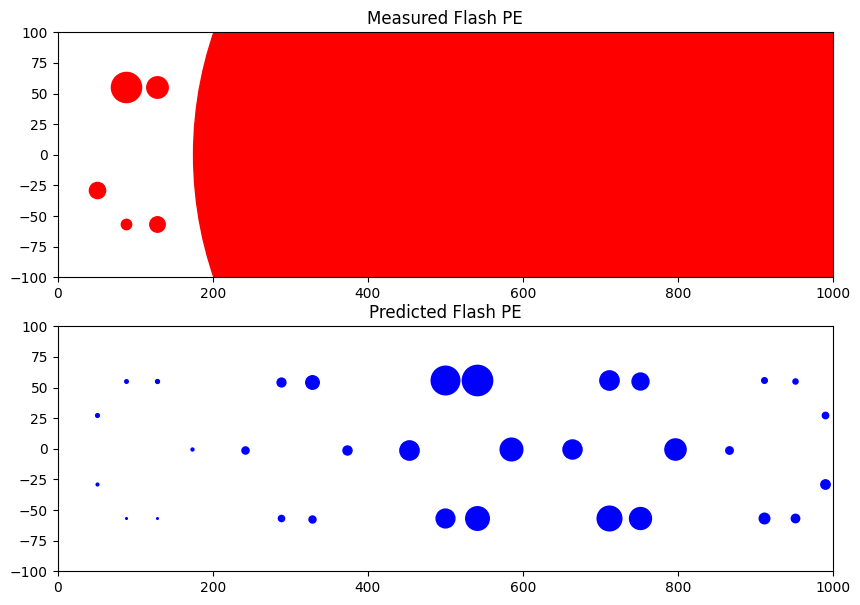

np.float32(212.78363)

In [ ]:
# view an event with measured/predicted flash pe

event_id = 3098

fig, axs = plt.subplots(2, 1, figsize=(10, 7))

meas_pmt_array = pmt_df['flash_pe_flash_matching_v'].to_numpy()
pred_pmt_array = pmt_df["slice_pe_flash_matching_v"].to_numpy()

for pmt_id in range(32):
    reco_pmt_position = reco_position_dic[pmt_id]
    meas_flash_pe = meas_pmt_array[event_id][pmt_id]
    #print(pmt_id, meas_flash_pe)
    pred_flash_pe = pred_pmt_array[event_id][pmt_id]
    #print(pmt_id, pred_flash_pe)
    size_scale = 75
    axs[0].scatter(reco_pmt_position[2], reco_pmt_position[1], color="red", s=meas_flash_pe * size_scale)
    axs[1].scatter(reco_pmt_position[2], reco_pmt_position[1], color="blue", s=pred_flash_pe * size_scale)

axs[0].set_xlim(0, 1000)
axs[0].set_ylim(-100, 100)
axs[1].set_xlim(0, 1000)
axs[1].set_ylim(-100, 100)

axs[0].set_title("Measured Flash PE")
axs[1].set_title("Predicted Flash PE")

plt.show()

meas_pmt_array[event_id][1]



In [ ]:
# total summed pmts (measured-predicted) / predicted

signal_and_background_indices = []

signal_and_background_indices = wc_df[(wc_df['background_v2'] == True) | (wc_df['signal_v2'] == True)].index

print(signal_and_background_indices)


Index([    1,     2,     4,     5,     6,     7,     8,     9,    10,    11,
       ...
       43187, 43188, 43195, 43198, 43199, 43200, 43207, 43209, 43210, 43211],
      dtype='int64', length=20833)


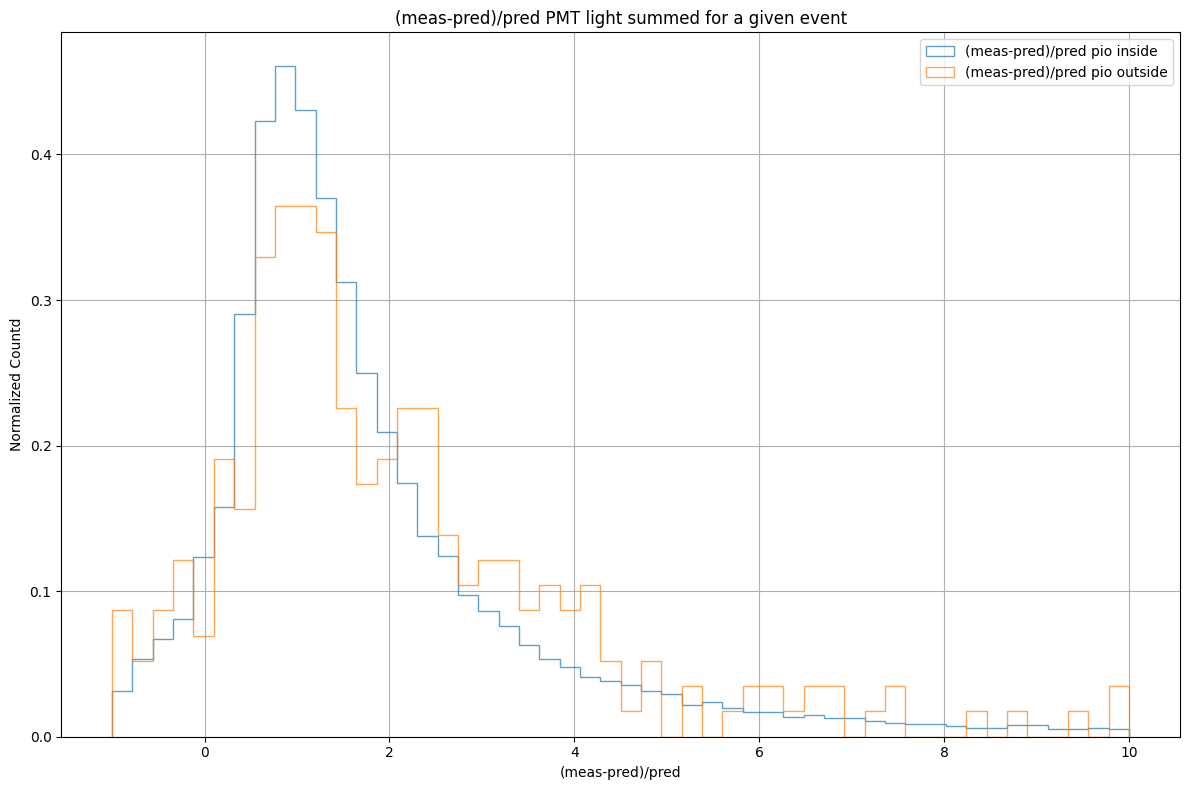

In [ ]:

#df = wc_df['signal_and_bkgrnd_df'].to_numpy()

measured_total = np.zeros(wc_df.shape[0])
pred_total = np.zeros(wc_df.shape[0])

for event_i in wc_df.index:
    measured_total[event_i] = np.sum(meas_pmt_array[event_i])
    pred_total[event_i] = np.sum(pred_pmt_array[event_i])
    
wc_df['meas_total'] = measured_total
wc_df['pred_total'] = pred_total

meas_minus_pred_arr = np.zeros(wc_df.shape[0])

meas_over_pred_arr = np.zeros(wc_df.shape[0])

mask = pred_total != 0
meas_minus_pred_arr[mask] = (measured_total[mask] - pred_total[mask]) / pred_total[mask]

meas_over_pred_arr[mask] = measured_total[mask] / pred_total[mask]

wc_df['meas_minus_pred'] = meas_minus_pred_arr

wc_df['meas_over_pred'] = meas_over_pred_arr

big_bigger_df = wc_df[wc_df['meas_minus_pred'] > 200]

#print(big_bigger_df['meas_total'], big_bigger_df['pred_total'])

signal_df = wc_df[wc_df["signal_v2"] == True]
background_df = wc_df[wc_df["background_v2"] == True]

pio_inside_df = wc_df[(wc_df['pi0_inside'] == True) & (wc_df['kine_reco_Enu'] > 0)]
pio_outside_df = wc_df[(wc_df['pi0_inside'] == False) & (wc_df['kine_reco_Enu'] > 0)]

plt.figure(figsize=(12, 8))

plt.hist(pio_inside_df["meas_minus_pred"], bins=50, range=(-1, 10), alpha=0.7, label='(meas-pred)/pred pio inside', histtype='step', stacked=True, fill=False, density = True)
plt.hist(pio_outside_df['meas_minus_pred'], bins=50, alpha=0.7, range=(-1, 10), label='(meas-pred)/pred pio outside', histtype='step', stacked=True, fill=False, density = True)
plt.xlabel('(meas-pred)/pred')
plt.ylabel('Normalized Countd')
plt.title("(meas-pred)/pred PMT light summed for a given event") # generally signal should be higher
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

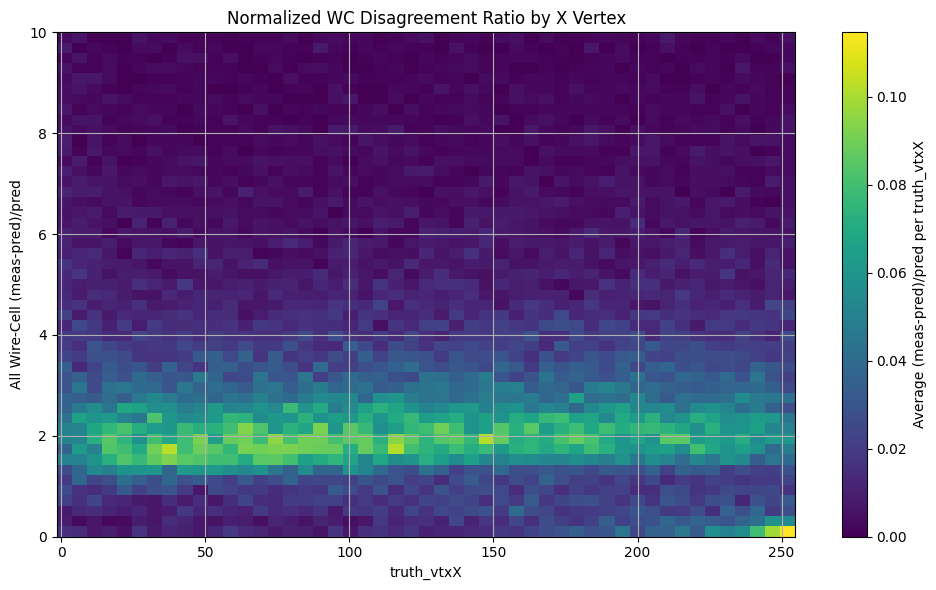

In [ ]:
# look at all pmt light as a funciton of x vertex

x_bins = np.linspace(wc_df['truth_vtxX'].min(), wc_df['truth_vtxX'].max(), 50)
y_bins = np.linspace(wc_df['meas_minus_pred'].min(), 10, 50)

# 2D histogram: counts in (X, ratio)
H2D, xedges, yedges = np.histogram2d(
    wc_df['truth_vtxX'], 
    wc_df["meas_minus_pred"], 
    bins=[x_bins, y_bins]
)

# 1D histogram: counts per X bin
H1D, _ = np.histogram(wc_df['truth_vtxX'], bins=x_bins)

# Normalize the 2D histogram by the 1D counts
H1D = H1D.astype(float)
H1D[H1D == 0] = np.nan # Avoid division by zero by masking

H2D_norm = (H2D.T / H1D).T  # normalize each column (meas_minus_pred) by row sum in x

# Plot the normalized 2D histogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(xedges, yedges, H2D_norm.T, cmap='viridis')
plt.colorbar(label='Average (meas-pred)/pred per truth_vtxX')
plt.xlabel('truth_vtxX')
plt.ylabel('All Wire-Cell (meas-pred)/pred')
plt.title('Normalized WC Disagreement Ratio by X Vertex')
plt.grid(True)
plt.tight_layout()
plt.show()

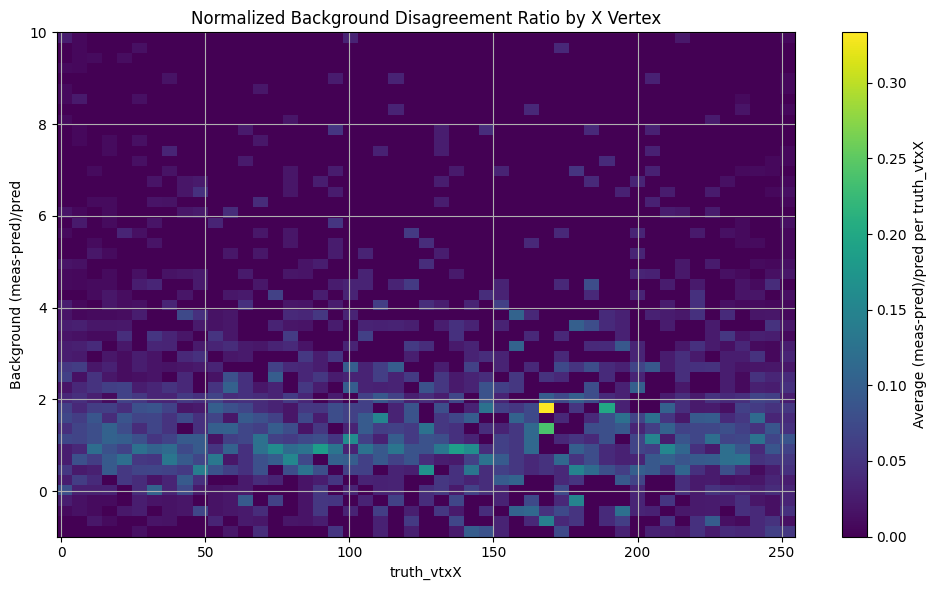

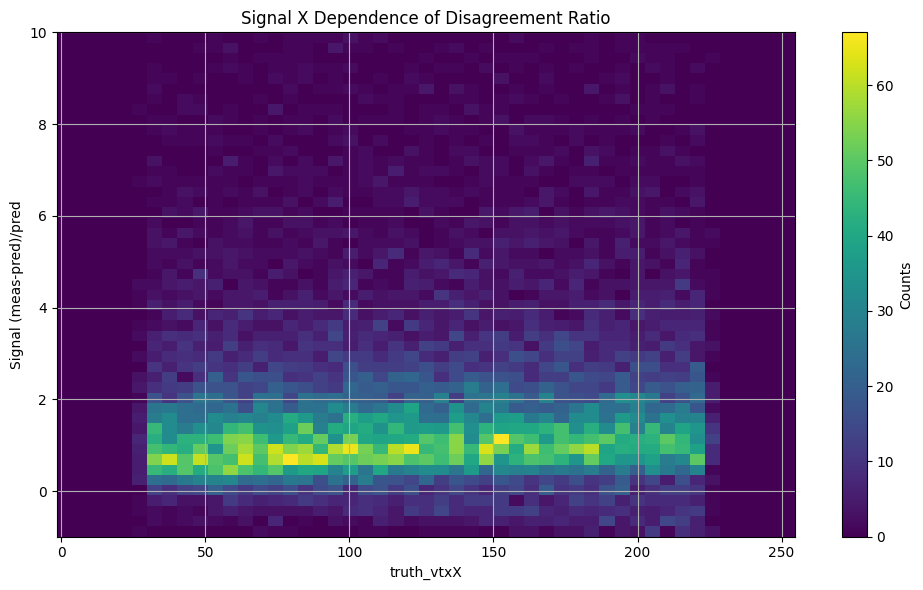

In [ ]:
# look at location dependence of above

# Define your binning (ensure x_bins is consistent across both histograms)
x_bins = np.linspace(background_df['truth_vtxX'].min(), background_df['truth_vtxX'].max(), 50)
y_bins = np.linspace(background_df['meas_minus_pred'].min(), 10, 50)

background_nux = background_df['truth_vtxX'].to_numpy()
background_disagreement = background_df['meas_minus_pred'].to_numpy()

# 2D histogram: counts in (X, ratio)
H2D, xedges, yedges = np.histogram2d(
    background_df['truth_vtxX'], 
    background_df["meas_minus_pred"], 
    bins=[x_bins, y_bins]
)

# 1D histogram: counts per X bin
H1D, _ = np.histogram(background_df['truth_vtxX'], bins=x_bins)

# Normalize the 2D histogram by the 1D counts
H1D = H1D.astype(float)
H1D[H1D == 0] = np.nan # Avoid division by zero by masking

H2D_norm = (H2D.T / H1D).T  # normalize each column (meas_minus_pred) by row sum in x

# Plot the normalized 2D histogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(xedges, yedges, H2D_norm.T, cmap='viridis')
plt.colorbar(label='Average (meas-pred)/pred per truth_vtxX')
plt.xlabel('truth_vtxX')
plt.ylabel('Background (meas-pred)/pred')
plt.title('Normalized Background Disagreement Ratio by X Vertex')
plt.grid(True)
plt.tight_layout()
plt.show()



plt.figure(figsize=(10, 6))
plt.hist2d(signal_df['truth_vtxX'], signal_df["meas_minus_pred"], bins=[x_bins , y_bins], cmap='viridis')
plt.colorbar(label='Counts')
plt.xlabel('truth_vtxX')
plt.ylabel('Signal (meas-pred)/pred')
plt.title('Signal X Dependence of Disagreement Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
neutrino_inside = background_df['truth_vtxInside'].to_numpy()

print(np.sum(neutrino_inside), np.shape(neutrino_inside))

2328 (2618,)


In [ ]:
# identify PMTs near closest point / expected exit point

meas_pmt_array = pmt_df['flash_pe_flash_matching_v'].to_numpy()
pred_pmt_array = pmt_df["slice_pe_flash_matching_v"].to_numpy()

event_id = 3098

closest_points = wc_df['missed_shw_closest_pt'].to_numpy()
vtx_inside = wc_df["truth_vtxInside"]

pmt_point_distances_dic = {}
for pmt_id in range(32):
    reco_pmt_position = reco_position_dic[pmt_id]
    pmt_point_distances_dic[pmt_id] =  np.sum(np.power(reco_pmt_position - closest_points[event_id], 2)) 
    
    meas_flash_pe = meas_pmt_array[event_id][pmt_id]
    #print(pmt_id, meas_flash_pe)
    pred_flash_pe = pred_pmt_array[event_id][pmt_id]
    #print(pmt_id, pred_flash_pe)
    size_scale = 75
    axs[0].scatter(reco_pmt_position[2], reco_pmt_position[1], color="red", s=meas_flash_pe * size_scale)
    axs[1].scatter(reco_pmt_position[2], reco_pmt_position[1], color="blue", s=pred_flash_pe * size_scale)


def closest_pmts(i, point):
    pmt_point_distances_dic = {}
    for pmt_id in range(32):
        reco_pmt_position = reco_position_dic[pmt_id]
        pmt_point_distances_dic[pmt_id] = np.sum(np.power(reco_pmt_position - closest_points[event_id], 2)) 
        
        meas_flash_pe = meas_pmt_array[event_id][pmt_id]
        #print(pmt_id, meas_flash_pe)
        pred_flash_pe = pred_pmt_array[event_id][pmt_id]


inside = []
outside = []
for i in range(len(missed_shw_events)):
    missed_event = missed_shw_events[i]
    blips_elist, blip_dist_list = blips_in_rad(missed_event, closest_points[missed_event], 20)
    if vtx_inside[missed_event]:
        inside.append(len(blips_elist))
    else:
        outside.append(len(blips_elist))
        
print(np.average(inside))
print(np.average(outside))





# since friday

In [304]:
# list of things to do as discussed in my meeting with lee and mark YOU MUST DO ALL OF THIS BEFORE MONDAY, give a comprehensive 

# 2. see position spread of the neutrino vertex across all events
# 3. separate out signal and background with the new files
# 4. redo # 2 with signal and background with extra event
###### make sure that lee's definition of location allows for shower vertexes outside of tpc in locations that make sense
# 5. put showers on the event displays
# 6. see if that small 'red' region has a higher concentration of positive (meas-pred)/pred
# 7. separate out A/B/C and see where has the largest average 


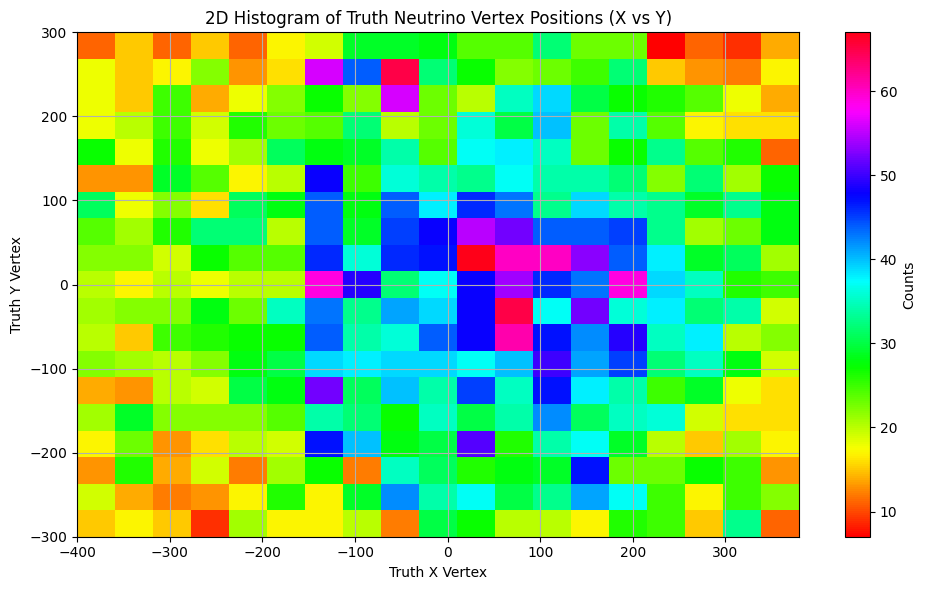

In [317]:
# position spread of neutrino vertex for each event subset

true_nu_xs = true_gamma_dirt_df['true_nu_vtx_x'].to_numpy()
true_nu_ys = true_gamma_dirt_df['true_nu_vtx_y'].to_numpy()
true_nu_zs = true_gamma_info_df['true_nu_vtx_z'].to_numpy()

#x_bins = np.linspace(np.min(true_nu_xs),np.max(true_nu_xs), 50)
#y_bins = np.linspace(np.min(true_nu_ys), np.max(true_nu_ys), 50)

x_bins = np.linspace(-400,380, 20)
y_bins = np.linspace(-300, 300, 20)

plt.figure(figsize=(10, 6))
plt.hist2d(true_nu_xs,true_nu_ys, bins=[x_bins, y_bins], cmap='hsv')

plt.colorbar(label='Counts')
plt.xlabel('Truth X Vertex')
plt.ylabel('Truth Y Vertex')
plt.title('2D Histogram of Truth Neutrino Vertex Positions (X vs Y)')
plt.grid(True)
plt.tight_layout()
plt.show()
